##### Import Packages

In [1]:
import os
import wget
import zipfile
from os.path import exists
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
pd.set_option('display.max_columns',None)

##### Loading Data

In [2]:
# Download if not available
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"
dataset_number = "00602"
if not exists(bean_data_file):
    filename = "DryBeanDataset.zip"
    url = base + dataset_number + "/" + filename
    wget.download(url)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')
    os.remove(filename)

In [3]:
# Read in the data from Excel file
bean_data_file = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"
beans = pd.read_excel(bean_data_file)
print(beans.shape)
beans.head()

(13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


The model was trained in ancient times by some legendary dude who left the
company a long time ago. It’s a Naive Bayes model. And it sucks. This is his
code:

In [4]:
# Labels are characters but should be integers for sklearn
le = LabelEncoder()
beans["Class"] = le.fit_transform(beans["Class"])
# Split data into classification target and features
y = beans["Class"]
X = beans.drop("Class", axis = 1)
# Split of training data
X_train, X_rest1, y_train, y_rest1 = train_test_split(
X, y, train_size=10000, random_state=2
)
# From the remaining data, split of test data
X_test, X_rest2, y_test, y_rest2 = train_test_split(
X_rest1, y_rest1, train_size=1000, random_state=42
)
# Split remaining into calibration and "new" data
X_calib, X_new, y_calib, y_new = train_test_split(
X_rest2, y_rest2, train_size=1000, random_state=42
)
# Fit the model
model = GaussianNB().fit(X_train, y_train)

Instead of splitting the data only into training and testing, we split the 13,611
beans into:
- 10,000 data samples (X_train, y_train) for training the model
- 1,000 data samples (X_test, y_test) for evaluating model performance
- 1,000 data samples (X_calib, y_calib) for calibration (more on that later)
- The remaining 1,611 data samples (X_new, y_new) for the conformal prediction step and for evaluating the conformal predictor (more on that later)

The dude didn’t even bother to tune hyperparameters or do model selection.
Yikes. Well, let’s have a look at the predictive performance:

In [5]:
# Check accuracy
y_pred = model.predict(X_test)
print("Accuracy:", (y_pred == y_test).mean())
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

Accuracy: 0.758
          BARBUNYA  BOMBAY  CALI  DERMASON  HOROZ  SEKER  SIRA
BARBUNYA        46       0    47         0      6      0     4
BOMBAY           0      33     0         0      0      0     0
CALI            20       0    81         0      3      0     0
DERMASON         0       0     0       223      0     32     9
HOROZ            0       0     4         3    104      0    22
SEKER            2       0     0        26      1    127    22
SIRA             0       0     0        10     10     21   144


75.80% of the beans in the test data are classified correctly.

The classes seem to have different classification difficulties, for example Bombay
is always classified correctly in the test data, but Barbunya only half of the time.

The dry bean company is in trouble. Several customers have complained that
they bought bags of one variety of beans but there were too many beans of other
varieties mixed in.

The bean company holds an emergency meeting and it’s decided that they will
offer premium products with a guaranteed percentage of the advertised bean
variety. For example, a bag labeled “Seker” should contain at least 95% Seker
beans

##### First try: a naive approach

Great, now all the pressure is on the data scientist to provide such guarantees all based on this bad model. Her first approach is the “naive approach” to uncertainty which means taking the probability outputs and believing in them. So instead of just using the class, she takes the predicted probability score, and if that score is above 95%, the bean makes it into the 95% bag.

It’s not yet clear what to do with beans that don’t make the cut for any of the classes, but stew seems to be the most popular option among the employees. The data scientist doesn’t fully trust the model scores, so she checks the coverage of the naive approach. Fortunately, she has access to new, labeled data that she can use to estimate how well her approach is working.

She obtains the probability predictions for the new data, keeps only beans with >=0.95 predicted probability, and checks how often the ground truth is actually in that 95% bag.

In [6]:
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the highest probability
high_prob_predictions = np.amax(predictions, axis=1)
# Select the predictions where probability over 99%
high_p_beans = np.where(high_prob_predictions >= 0.95)
# Let's count how often we hit the right label
its_a_match = (model.predict(X_calib) == y_calib)
coverage = np.mean(its_a_match.values[high_p_beans])
print(round(coverage, 3))

0.896


Ideally, 95% or more of the beans should have the predicted class, but she finds that the 95%-bag only contains 89.6% of the correct variety.

Now what?

She could use methods such as Platt scaling or isotonic regression to calibrate these probabilities, but again, with no guarantee of correct coverage for new data.

But she has an idea.

#####  Second try: conformal classification

The data scientist decides to think about the problem in a different way: she doesn’t start with the probability scores, but with how she can get a 95% coverage guarantee.

Can she produce a set of predictions for each bean that covers the true class with 95% probability? It seems to be a matter of finding the right threshold.

So she does the following:

She ignores that the output could be a probability. Instead, she uses the model “probabilities” to construct a measure of uncertainty:

𝑠<sub>𝑖</sub> = 1 − 𝑓(𝑥<sub>𝑖</sub>)[𝑦<sub>𝑖</sub>]

A slightly sloppy notation for saying that we take 1 minus the model score for the true class. For example, if the ground truth for bean number 8 is “Seker” and the probability score for Seker is 0.9, then 𝑠<sub>8</sub> = 0.1. In conformal prediction language, this 𝑠<sub>𝑖</sub>-score is called non-conformity score.

Then she does the following to find the threshold:
1. Start with data not used for model training
2. Calculate the scores 𝑠<sub>𝑖</sub>
3. Sort the scores from low (certain) to high (uncertain) : This step seems to be immaterial
4. Compute the threshold ̂𝑞 where 95% of the 𝑠<sub>𝑖</sub>’s are smaller (=95% quantile)

The threshold is therefore chosen to cover 95% of the true bean classes.




In [12]:
# Size of calibration data
n = len(X_calib)
# Get the probability predictions
predictions = model.predict_proba(X_calib)
# We only need the probability for the true class
prob_true_class = predictions[np.arange(n),y_calib]
# Turn into uncertainty score (larger means more uncertain)
scores = 1 - prob_true_class

Next, she has to find the cut-of

In [28]:
# Setting the alpha so that we get 95% prediction sets
alpha = 0.05
# define quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(scores, q_level, method='higher')
q_level, qhat

(np.float64(0.951), np.float64(0.9990629054637845))

The quantile level (based on 𝛼) requires a finite sample correction to calculate the corresponding quantile . In this case, the 0.95 was multiplied with (n+1)/n ̂𝑞 which means that 𝑞<sub>𝑙𝑒𝑣𝑒𝑙</sub> = 0.951 for n = 1000.

If we visualize the scores, we can see that it’s a matter of cutting off at the right
position:

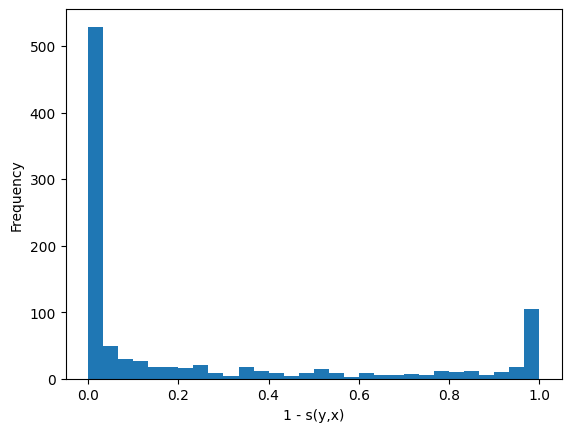

In [29]:
# Get the "probabilities" from the model
predictions = model.predict_proba(X_calib)
# Get for each instance the actual probability of ground truth
prob_for_true_class = predictions[np.arange(len(y_calib)),y_calib]
# Create a histogram
plt.hist(1 - prob_for_true_class, bins=30, range=(0, 1))
# Add a title and labels
plt.xlabel("1 - s(y,x)")
plt.ylabel("Frequency")
plt.show()

How does the threshold come into play?

For the figure above, we would cut off all above ̂𝑞 = 0.99906. Because for bean scores 𝑠<sub>𝑖</sub> below 0.99906 (equivalent to class “probabilities” > 0.001), we can be confident that we have the right class included (in the prediction set) 95% of the time.

But there’s a catch: For some data points, there will be more than one class that makes the cut. But prediction sets are not a bug, they are a feature of conformal prediction.

What is a prediction set?

A prediction set – for multi-class tasks – is a set of one or more classes. Conformal classification gives you a set for each instance.

To generate the prediction sets for a new data point, the data scientist has to combine all classes that are below the threshold ̂𝑞 into a set

Let’s look at the prediction sets for 3 “new” beans (X_new):

In [31]:
prediction_sets = (1 - model.predict_proba(X_new) <= qhat)

In [32]:
for i in range(3):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']


On average, the prediction sets cover the true class with a probability of 95%. That’s the guarantee we get from the conformal procedure.

How could the bean company work with such prediction sets? The first set has
only 1 bean variety “DERMASON”, so it would go into a DERMASON bag.
Beans #3 has a prediction set with two varieties. Maybe a chance to offer bean
products with guaranteed coverage, but containing two varieties? Anything with
more categories could be sorted manually, or the CEO could finally make bean
stew for everyone.

The CEO is now more relaxed and confident in the product.

Spoiler alert: the coverage guarantees don’t work the way the bean CEO thinks
they do, as we will soon learn (what they actually need is a class-wise coverage
guarantee that we will learn about in the classification chapter.)

And that’s it. You have just seen conformal prediction in action. To be exact,
this was the score method that you will encounter again in the classification
chapter.


##### Getting started with MAPIE

The data scientist could also have used MAPIE4 , a Python library for conformal prediction.


In [33]:
from mapie.classification import MapieClassifier
cp = MapieClassifier(estimator=model, cv="prefit", method="lac") #lac was previously the "score" method
cp.fit(X_calib, y_calib)
y_pred, y_set = cp.predict(X_new, alpha=0.05)
y_set = np.squeeze(y_set)

We’re no longer working with the Naive Bayes model object, but our model is
now a MapieClassifier object. If you are familiar with the sklearn library, it will
feel natural to work with objects in MAPIE. These MAPIE objects have a .fitfunction and a .predict()-function, just like sklearn models do. MapieClassifier
can be thought of as wrapper around our original model.

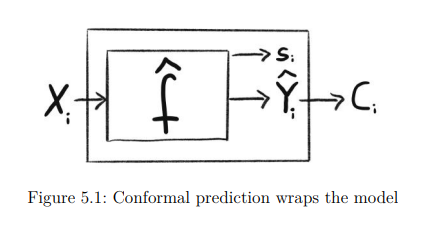

And when we use the “predict” method of this conformal classifier, we get both the
usual prediction (“y_pred”) and the sets from the conformal prediction (“y_set”).
It’s possible to specify more than one value for 𝛼. But in the code above only 1
value was specified, so the resulting y_set is an array of shape (1000, 7, 1), which
means 1000 data points, 7 classes, and 1 𝛼. The np.squeeze function removes the
last dimension.

Let’s have a look at some of the resulting prediction sets. Since the cp_score
only contains “True” and “False” at the corresponding class indices, we have to
use the class labels to get readable results. Here are the first 5 prediction sets for
the beans:

In [34]:
for i in range(5):
    print(le.classes_[y_set[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']
['DERMASON']
['DERMASON' 'SEKER']


In [38]:
le.classes_

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'],
      dtype=object)

In [37]:
y_pred[2]

np.int64(3)

In [36]:
y_set[2]

array([False, False, False,  True, False,  True, False])

These prediction sets are of size 1 or 2. Let’s have a look at all the other beans
in X_new:

In [42]:
# first count number of classes per bean
set_sizes = y_set.sum(axis=1)
# use pandas to compute how often each size occurs
print(pd.Series(set_sizes).value_counts(normalize=True))


2    0.540658
1    0.314091
3    0.144631
4    0.000621
Name: proportion, dtype: float64
